In [1]:
import sys
import os

In [2]:
sys.path.append(os.path.abspath('../../app'))

In [34]:
!pip install huggingface-hub
!pip install matplotlib
!pip install datasets

In [3]:
from huggingface_hub import hf_hub_download
from core.feluda import Feluda
from core.models.media_factory import VideoFactory
import cv2
import tarfile
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

/usr/app/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



### Dataset Structure Breakdown

- **UCF101_subset/**: The root directory containing the dataset.
  - **train/**: Contains training samples.
    - Each subdirectory under `train/` corresponds to a specific action class:
      - `BenchPress`
      - `BasketballDunk`
      - `BalanceBeam`
      - `ApplyLipstick`
      - `BabyCrawling`
      - `ApplyEyeMakeup`
      - `Archery`
      - `BandMarching`
      - `BaseballPitch`
      - `Basketball`
  - **test/**: Same as train.
  - **val/**: Same as train.

We'll take train subset as our example here.

In [4]:
# Downloading and extracting 

dataset_name = "UCF101_subset/train"
hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset")


with tarfile.open(file_path) as t:
     t.extractall(".")


In [5]:
file_path

'/home/python/.cache/huggingface/hub/datasets--sayakpaul--ucf101-subset/snapshots/b9984b8d2a95e4a1879e1b071e9433858d0bc24a/UCF101_subset.tar.gz'

### Initializing Feluda class with config file

We'll use two operators for this example. One for extracting embeddings and other for clustering.

In [8]:
feluda = Feluda("cluster-video-config.yml")
feluda.setup()

# Extracting operator name from config and getting operators from Feluda
cluster_operator = feluda.operators.get()[feluda.config.operators.parameters[0].type] 
vid_vec_clip_operator = feluda.operators.get()[feluda.config.operators.parameters[1].type]

Installing packages for vid_vec_rep_clip


In [10]:
def get_video_thumbnail(video_path, save_path):
    """Extract and save the first frame from the video as a thumbnail."""
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()  # Read the first frame
    if ret:
        thumbnail_path = os.path.join(save_path, os.path.basename(video_path).replace('.avi', '_thumbnail.jpg'))
        cv2.imwrite(thumbnail_path, frame)  # Save the thumbnail as a JPEG
        cap.release()
        return thumbnail_path  # Return the path to the saved thumbnail
    cap.release()
    return None

In the below codeblock, we are extracting embeddings from video using vid_vec_clip operator.

In [11]:
operator_parameter = []
sub_folder_name = os.listdir(f'{dataset_name}')

for class_dir in sub_folder_name:
    temp_list = os.listdir(os.path.join(dataset_name, class_dir))

    i = 0
    while i < len(temp_list) and i < 5:
        if temp_list[i] == 'UCF101':
            i += 1 
            continue
            
        video_full_path = os.path.join(dataset_name, class_dir, temp_list[i])

        # Extract and save the video thumbnail before processing
        thumbnail_save_dir = 'thumbnails'
        os.makedirs(thumbnail_save_dir, exist_ok=True) 
        thumbnail_path = get_video_thumbnail(video_full_path, thumbnail_save_dir)
        
        video_path = VideoFactory.make_from_file_on_disk(
            os.path.join(dataset_name, class_dir, temp_list[i])
        )
        embedding = vid_vec_clip_operator.run(video_path)
        average_vector = next(embedding)
        
        operator_parameter.append({
            "payload": os.path.join(dataset_name, class_dir, temp_list[i]),  # Use the current item as the payload
            "embedding": average_vector.get("vid_vec"),
        })
        i += 1


After extracting embeddings from vid_vec_clip operator, we now pass the embeddings to clustering operator to cluster videos based on their embeddings.

In [29]:
# Using clustering algorithm

clusters = cluster_operator.run(operator_parameter,n_clusters=10,modality='video')
clusters = {key: cluster[key] for key in sorted(cluster)} # Sorted based on keys

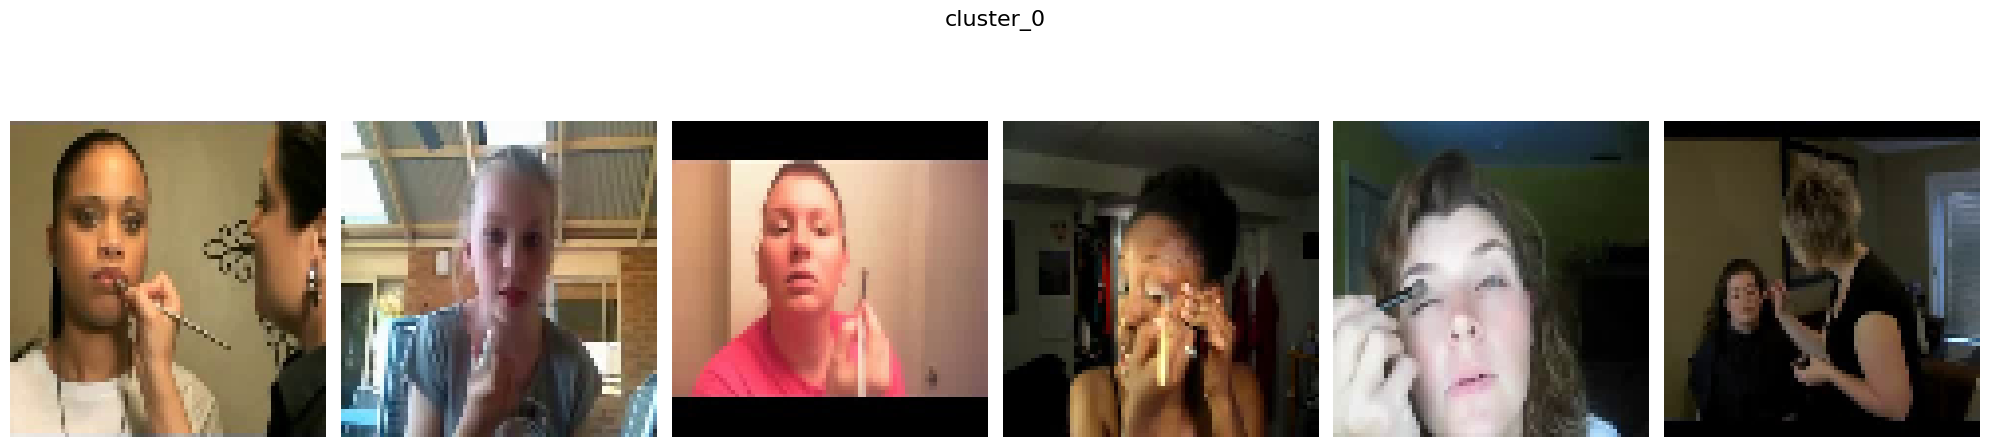

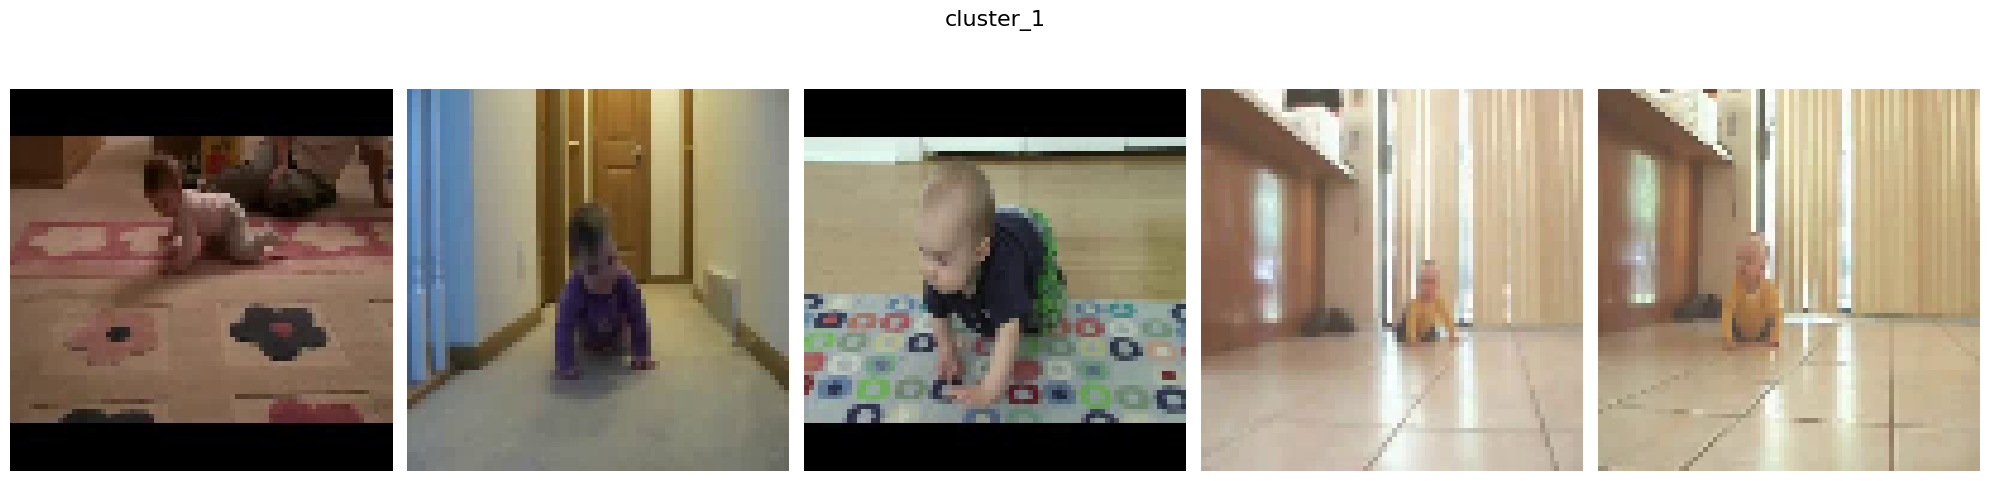

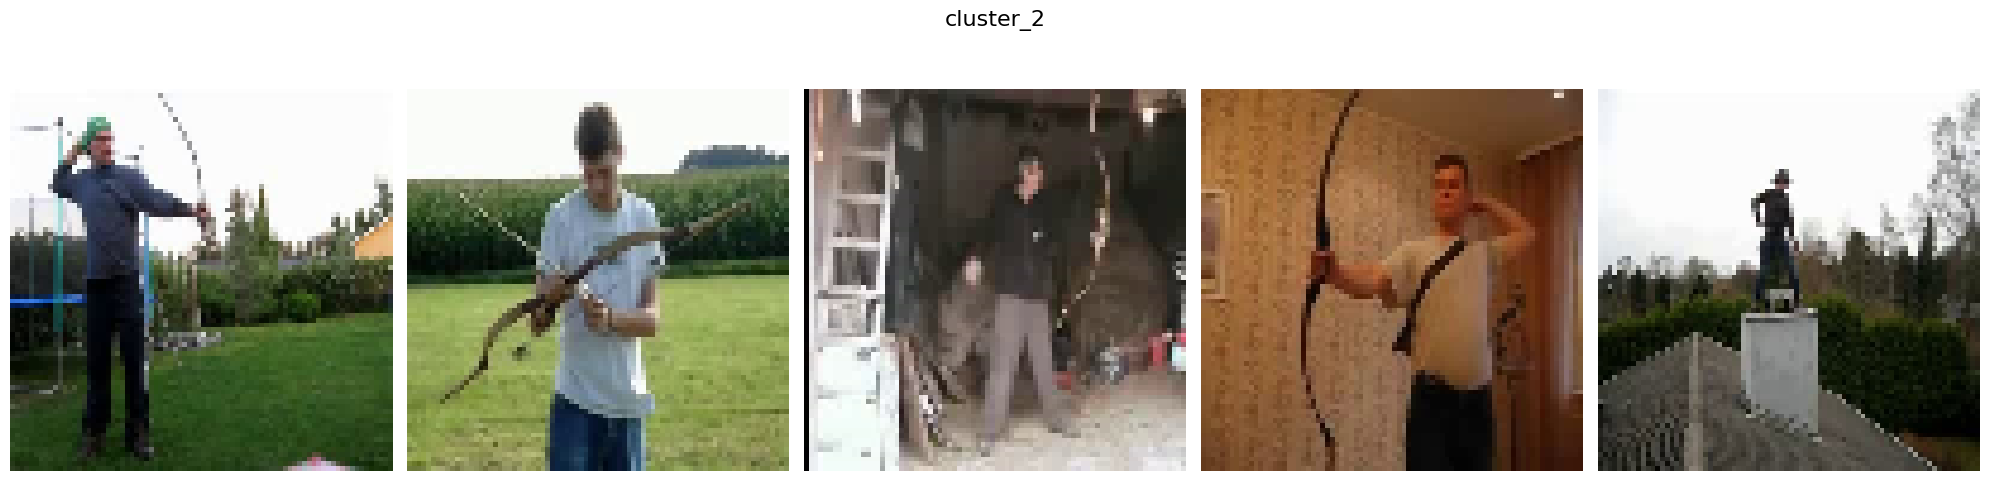

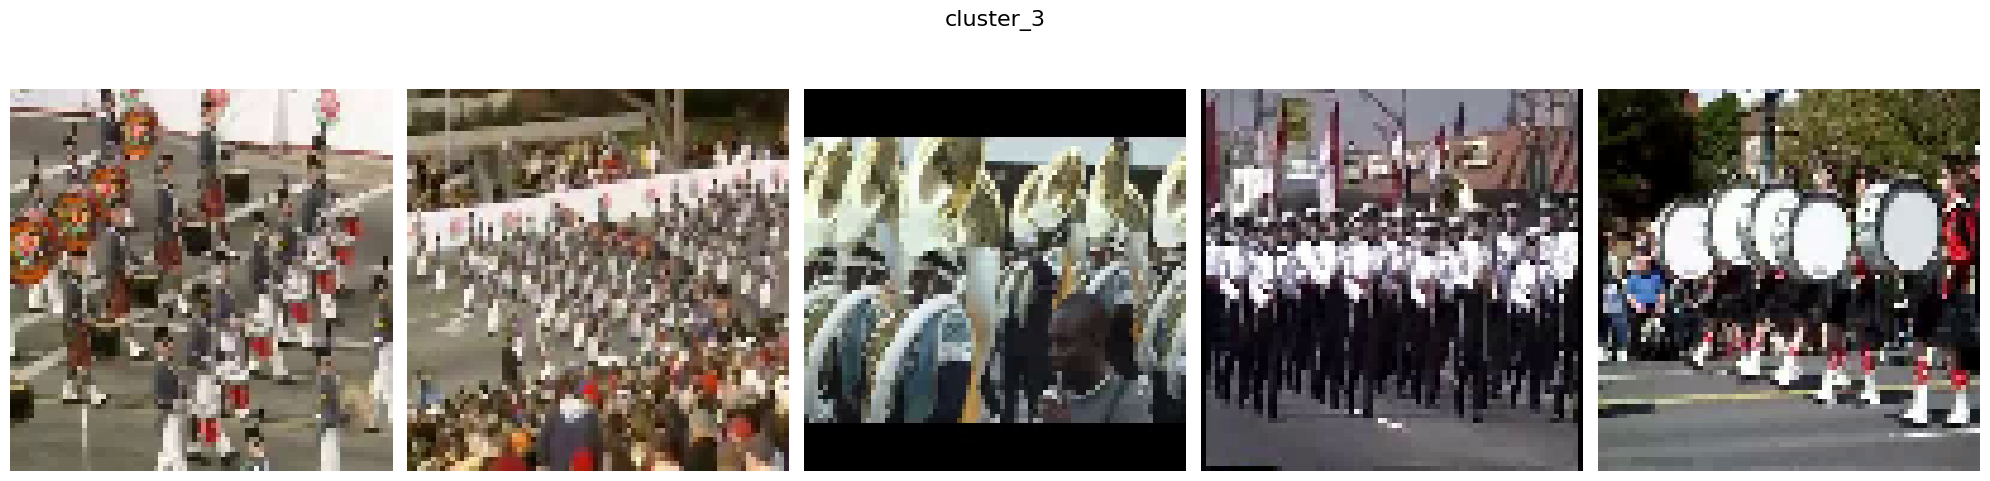

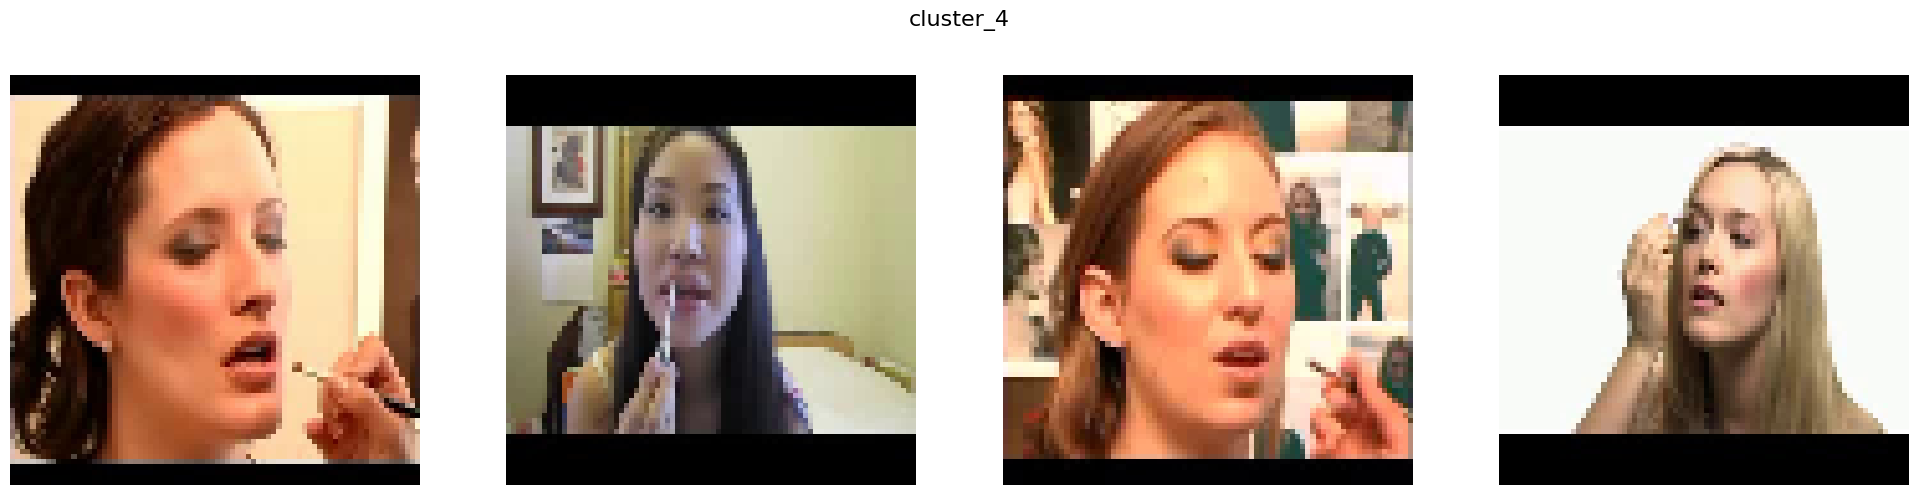

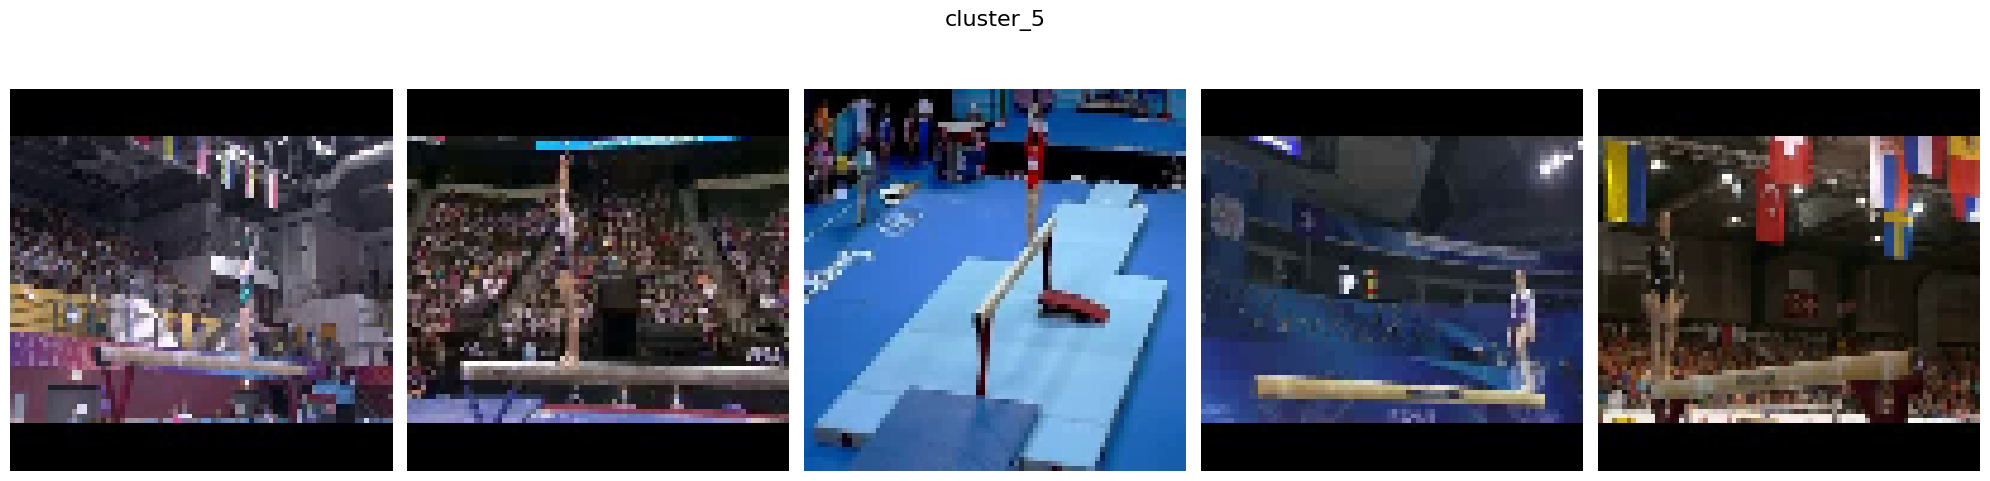

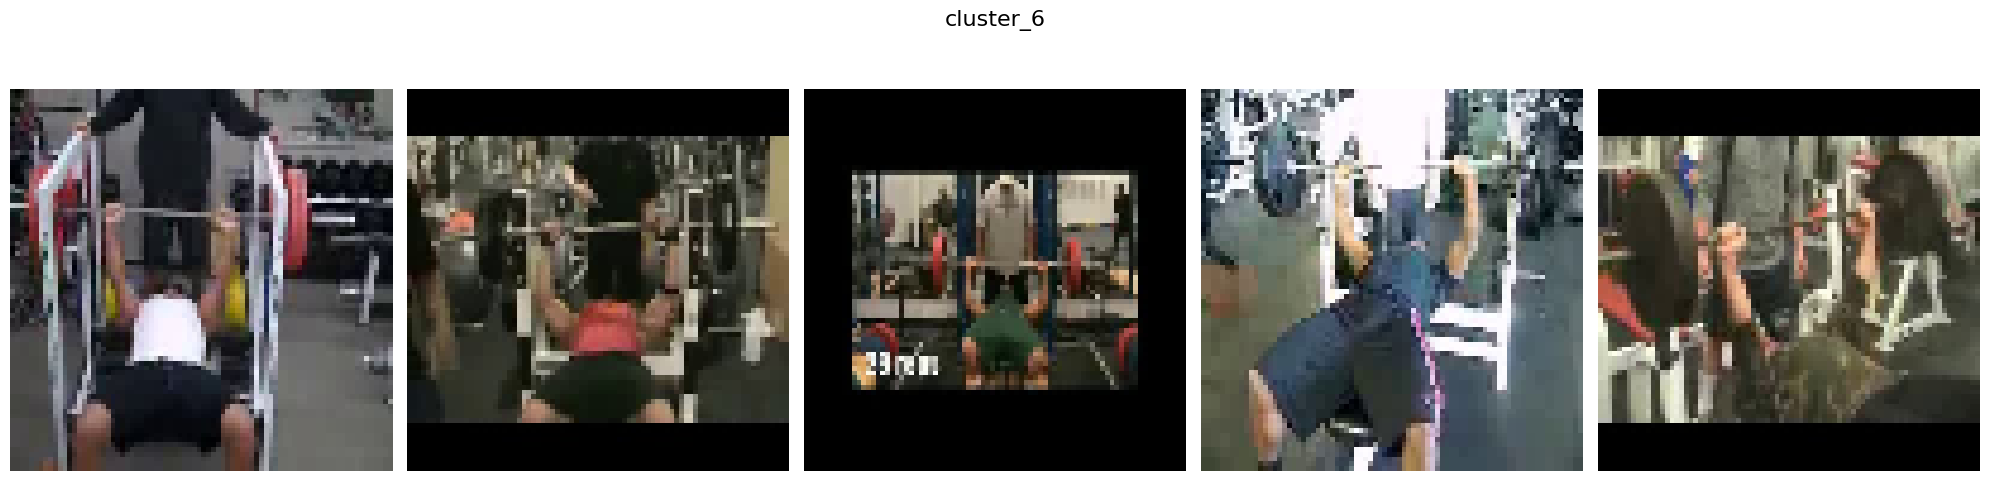

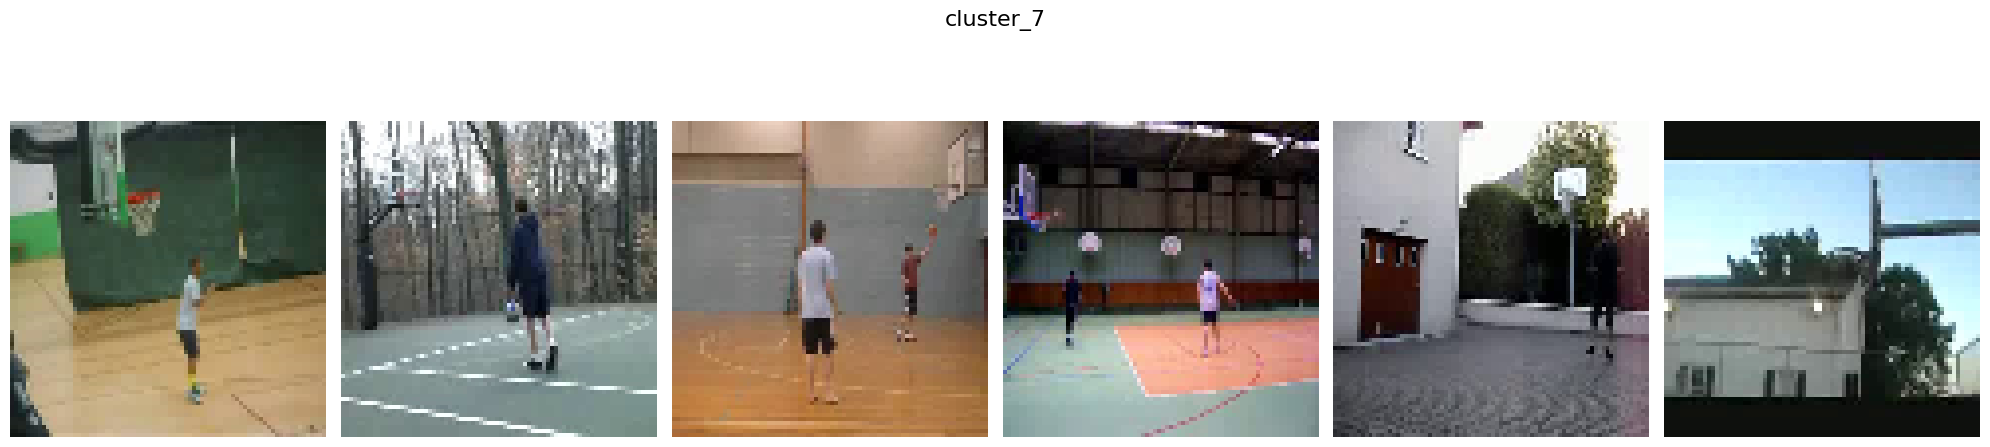

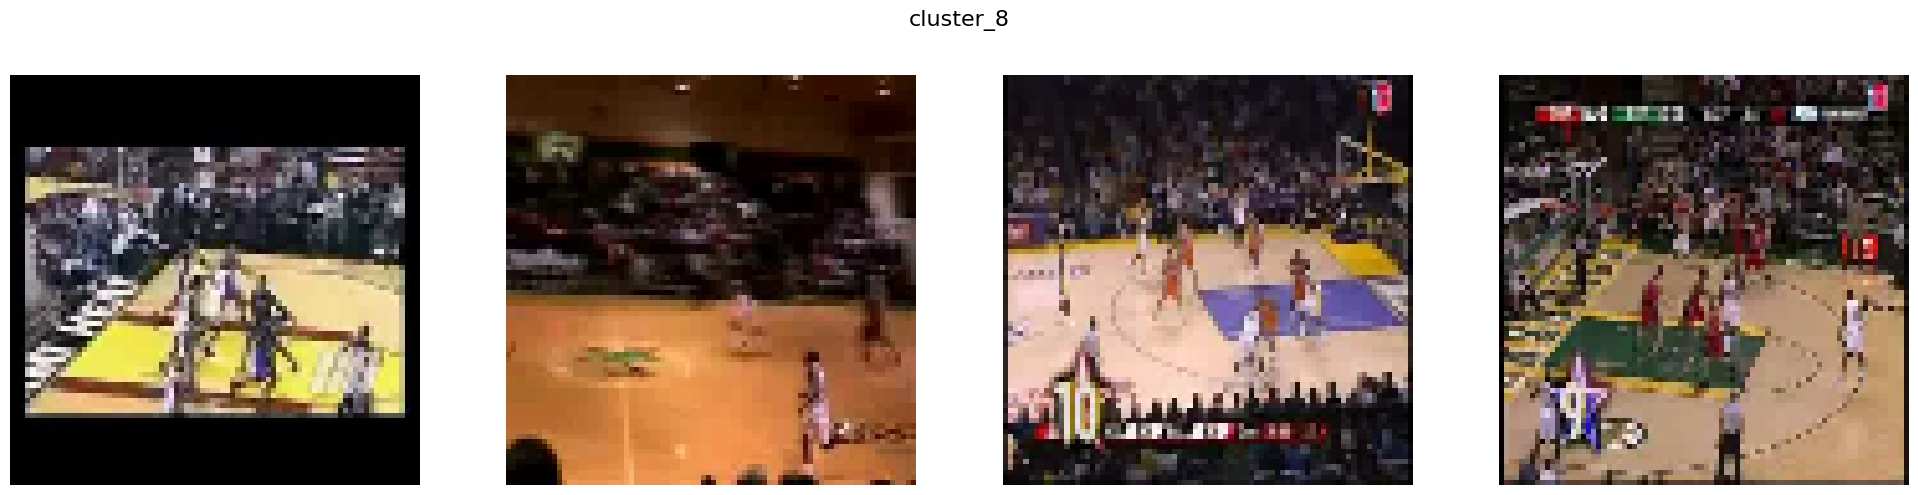

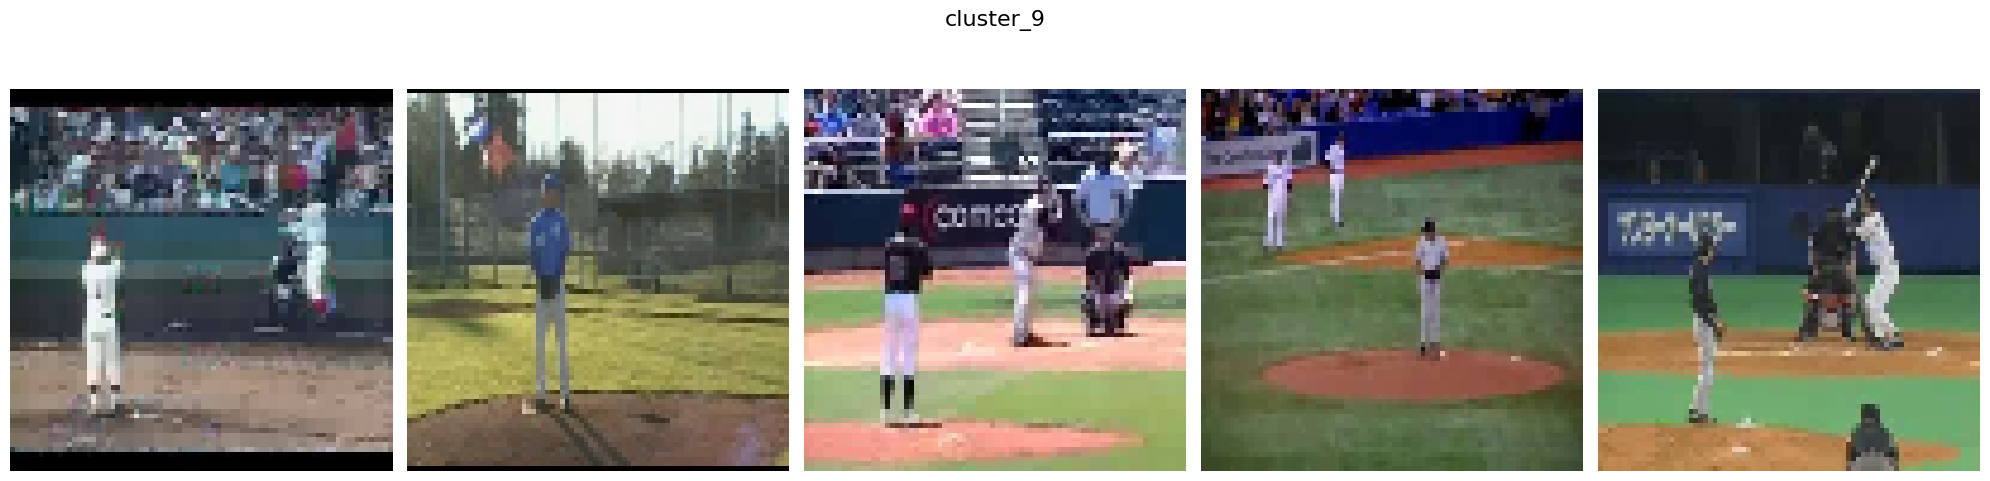

In [32]:

thumbnail_folder = 'thumbnails'

def load_thumbnail(payload):
    """Load the thumbnail from the pre-saved thumbnail folder."""
    video_filename = os.path.basename(payload)
    thumbnail_filename = video_filename.replace('.avi', '_thumbnail.jpg')
    thumbnail_path = os.path.join(thumbnail_folder, thumbnail_filename)
    
    if os.path.exists(thumbnail_path):
        return cv2.imread(thumbnail_path)
    else:
        print(f"Thumbnail not found for {video_filename}")
    return None

for cluster_label, video_paths in clusters.items():
    num_videos = len(video_paths)
    
    fig, axes = plt.subplots(1, num_videos, figsize=(20, 5))

    for i, video_path in enumerate(video_paths):
        video_thumbnail = load_thumbnail(video_path)
        if video_thumbnail is not None:
            video_thumbnail = cv2.cvtColor(cv2.resize(video_thumbnail, (80, 80)), cv2.COLOR_BGR2RGB)
            axes[i].imshow(video_thumbnail)
            axes[i].axis('off')
    
    plt.suptitle(f'{cluster_label}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


In [33]:
# Cleaning cell
import shutil

shutil.rmtree('thumbnails')
shutil.rmtree('UCF101_subset')
os.remove(file_path)